# Training a CNN with the 256x256 images.

In [22]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

from torchsummary import summary


## First Baseline Model

In this notebook, I will be training a shallow CNN with just the right breast MLO view using 256x256 images.

### Dataset Object

torch.Size([3, 256, 256])
tensor(0.)


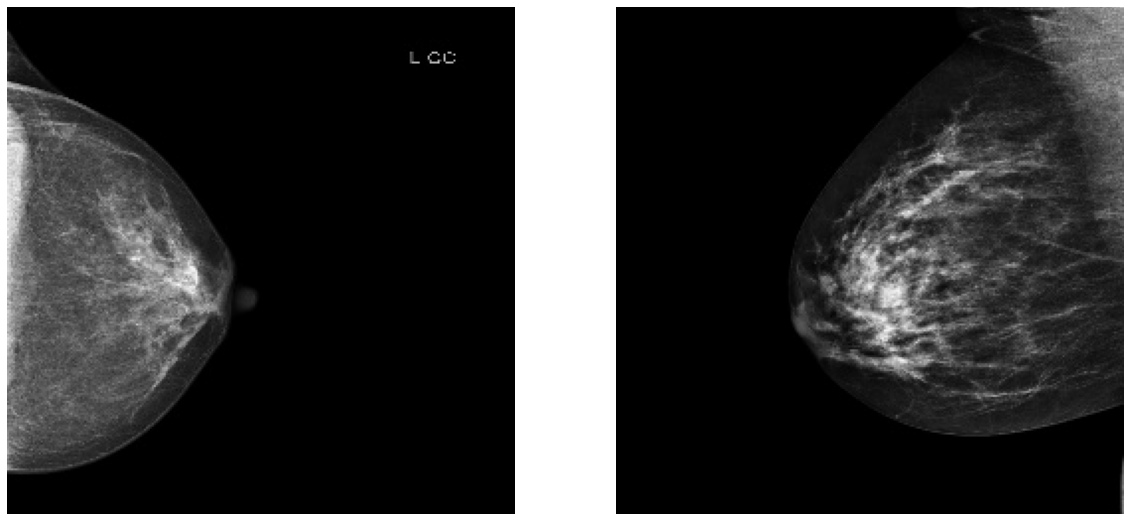

In [23]:
"""In this cell, I will be declaring the Dataset class, which will be used to load the images and the labels.
"""
df = pd.read_csv('./data/train.csv')
# df.sort_values(by='patient_id', inplace=True)
path_images = './data/256_images/'
list_images = sorted(os.listdir(path_images))

# I will need a torch Dataset to load the images and the labels.
class DatasetBreast(torch.utils.data.Dataset):
    """The labels will be available through df.cancer, whereas the images will be loaded from the /data/256_images folder.
    """
    def __init__(self, df, path_patients, transform=None):
        self.df = df
        self.path_patients = path_patients
        self.transform = transform
        self.list_patients = sorted(os.listdir(path_patients))
        self.list_patients = [x for x in self.list_patients if x != '.DS_Store']
        # From the list of patients, I will need to get access to the images
        self.list_images = []
        for patient in self.list_patients:
            for image in sorted(os.listdir(path_images + patient)):
                if image != '.DS_Store':
                    self.list_images.append(patient + '/' + image)
        self.list_images = sorted(self.list_images)
        self.labels = self.df.cancer.values
        self.labels = self.labels.astype(np.float32)
        self.labels = torch.from_numpy(self.labels)

    def __len__(self):
        return len(self.list_images)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Get the image
        path_image = self.path_patients + self.list_images[idx]
        image = plt.imread(path_image)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        image = image.permute(2, 0, 1)
        # Get the label it should be either 0 or 1
        label = self.labels[idx]
        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)
        return sample
    

dataset = DatasetBreast(df, path_images)
# Check if it is working
sample = dataset[5]
sample2 = dataset[20]
print(sample['image'].shape)
print(sample['label'])

# Show the image as a numpy array int32
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(sample['image'].permute(1, 2, 0).numpy().astype(np.int32))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sample2['image'].permute(1, 2, 0).numpy().astype(np.int32))
plt.axis('off')
plt.show()


### Train-validation-test split

In [24]:
# Train-validation-test split
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create the dataloaders
size_batch = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=size_batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=size_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=size_batch, shuffle=True)

# Check if it is working
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), sample_batched['label'])
    if i_batch == 3:
        break


0 torch.Size([32, 3, 256, 256]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
1 torch.Size([32, 3, 256, 256]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
2 torch.Size([32, 3, 256, 256]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
3 torch.Size([32, 3, 256, 256]) tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


### Baseline Model (2D - Convolutional Neural Network)

In [25]:
"""Create 2D convolutional neural network for the classification task of the cancer images (binary classification), based on images 3x256x256. I will be using a mini batch size of 32"""

# Create a model
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, stride = 1, padding = 1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size = 2, stride = 2))
model.add_module('conv2', nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 5, stride = 1, padding = 1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size = 2, stride = 2))
model.add_module('conv3', nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 1, padding = 1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size = 2, stride = 2))
model.add_module('conv4', nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, stride = 1, padding = 1))
model.add_module('relu4', nn.ReLU())
model.add_module('pool4', nn.MaxPool2d(kernel_size = 2, stride = 2))
model.add_module('conv5', nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 5, stride = 1, padding = 1))
model.add_module('relu5', nn.ReLU())
model.add_module('pool5', nn.MaxPool2d(kernel_size = 2, stride = 2))

model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(in_features = 9216, out_features = 256))
model.add_module('relu6', nn.ReLU())
model.add_module('fc2', nn.Linear(in_features = 256, out_features = 64))
model.add_module('relu7', nn.ReLU())
model.add_module('fc3', nn.Linear(in_features = 64, out_features = 32))
model.add_module('relu8', nn.ReLU())
model.add_module('fc4', nn.Linear(in_features = 32, out_features = 8))
model.add_module('relu9', nn.ReLU())
model.add_module('fc5', nn.Linear(in_features = 8, out_features = 1))
model.add_module('sigmoid', nn.Sigmoid())



# Check if it is working
# sample = dataset[5]
# sample2 = dataset[20]
# print(sample['image'].shape)
# print(sample['label'])
# print(model(sample['image'].unsqueeze(0)).item())
# print(model(sample2['image'].unsqueeze(0)).item())

# Summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 254, 254]           2,432
              ReLU-2         [-1, 32, 254, 254]               0
         MaxPool2d-3         [-1, 32, 127, 127]               0
            Conv2d-4         [-1, 32, 125, 125]          25,632
              ReLU-5         [-1, 32, 125, 125]               0
         MaxPool2d-6           [-1, 32, 62, 62]               0
            Conv2d-7           [-1, 64, 60, 60]          51,264
              ReLU-8           [-1, 64, 60, 60]               0
         MaxPool2d-9           [-1, 64, 30, 30]               0
           Conv2d-10          [-1, 128, 28, 28]         204,928
             ReLU-11          [-1, 128, 28, 28]               0
        MaxPool2d-12          [-1, 128, 14, 14]               0
           Conv2d-13          [-1, 256, 12, 12]         819,456
             ReLU-14          [-1, 256,

In [28]:
# Train the model 

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0]*num_epochs
    loss_hist_valid = [0]*num_epochs
    accuracy_hist_train = [0]*num_epochs
    accuracy_hist_valid = [0]*num_epochs
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        for i, sample_batched in enumerate(train_dl):
            optimizer.zero_grad()
            outputs = model(sample_batched['image'])
            loss = criterion(outputs, sample_batched['label'].unsqueeze(1))
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item()
            accuracy_hist_train[epoch] += (outputs.round() == sample_batched['label'].unsqueeze(1)).sum().item()
        loss_hist_train[epoch] /= len(train_dl)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        model.eval()
        with torch.no_grad():
            for i, sample_batched in enumerate(valid_dl):
                outputs = model(sample_batched['image'])
                loss = criterion(outputs, sample_batched['label'].unsqueeze(1))
                loss_hist_valid[epoch] += loss.item()
                accuracy_hist_valid[epoch] += (outputs.round() == sample_batched['label'].unsqueeze(1)).sum().item()
        loss_hist_valid[epoch] /= len(valid_dl)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch+1, num_epochs, loss_hist_train[epoch], accuracy_hist_train[epoch]*100))
        return model, loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid
    
model, loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = train(model, num_epochs, train_loader, val_loader)

# Plot the loss and accuracy
plt.plot(loss_hist_train, label='Training loss')
plt.plot(loss_hist_valid, label='Validation loss')
plt.legend(frameon=False)
plt.show()



  0%|          | 0/10 [00:00<?, ?it/s]